In [47]:
import os
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd

In [2]:
from mxnet.gluon.data.vision.datasets import ImageFolderDataset
from mxnet.gluon.data import DataLoader
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models
from mxnet import gluon, nd, autograd

In [3]:
data_dir = "../../../data/data_v2" #main_data_dir

train_data_dir = f'{data_dir}/train'
validation_data_dir = f'{data_dir}/validation'

In [4]:
len(os.listdir(train_data_dir))

8

In [5]:
TARGET_SIZE = 224
SIZE = (TARGET_SIZE, TARGET_SIZE)
BATCH_SIZE = 32
NUM_WORKERS = 4#multiprocessing.cpu_count()

In [6]:
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

In [7]:
def transform(image, label):
     # resize the shorter edge to 224, the longer edge will be greater or equal to 224
    resized = mx.image.resize_short(image, TARGET_SIZE)
    # center and crop an area of size (224,224)
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    #transpose the channels to be (3,224,224)
    transposed = nd.transpose(cropped, (2,0,1))
    return transposed, label

In [8]:
dataset_train = ImageFolderDataset(root=train_data_dir, transform=transform)
dataset_test = ImageFolderDataset(root=validation_data_dir, transform=transform)

In [9]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS) # last_batch='discard' (removed for testing)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, # last_batch='discard',
                             shuffle=True, num_workers=NUM_WORKERS)
print("Train dataset: {} images, Test dataset: {} images".format(len(dataset_train), len(dataset_test)))

Train dataset: 4800 images, Test dataset: 1600 images


In [10]:
categories = dataset_train.synsets
NUM_CLASSES = len(categories)

In [11]:
categories

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [73]:
dataloader_train

## MOdel creation

In [56]:
# get pretrained squeezenet
net = models.resnet50_v2(pretrained=True, prefix='kavisar',ctx=ctx)

In [57]:
my_net = models.resnet50_v2(prefix='kavisar', classes=8, ctx=ctx)

In [58]:
my_net.collect_params().initialize(ctx=ctx)

In [59]:
my_net.features = net.features

In [72]:
len(dataset_test)

1600

In [77]:
metric_acc = mx.metric.Accuracy()
#metric_loss = mx.metric.Loss()

def evaluate_accuracy(data_iterator,loss_fn, net):
    numerator = 0.
    denominator = 0.
    cumulative_loss = 0.
    no_of_samples = 0

    for i, (data, label) in enumerate(data_iterator):
        with autograd.record():
            data = data.astype(np.float32).as_in_context(ctx)
            label = label.astype(np.int32).as_in_context(ctx)
            output = net(data)
            loss = loss_fn(output, label)
            prediction = nd.argmax(output, axis=1).astype(np.int32)
            cumulative_loss += nd.sum(loss).asscalar()
            no_of_samples += data.shape[0]

        metric_acc.update([label], [prediction])
        #metric_loss.update([label], [prediction])
    
    
    print("cumulative loss = {0} no_of_samples = {1}" .format(cumulative_loss, no_of_samples))
    loss = cumulative_loss / no_of_samples
    return (metric_acc.get()[1], loss)

In [ ]:
def evaluate_accuracy_gluon(data_iterator, net):
    num_instance = nd.zeros(1, ctx=ctx)
    sum_metric = nd.zeros(1,ctx=ctx, dtype=np.int32)
    for i, (data, label) in enumerate(data_iterator):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.astype(np.int32).as_in_context(ctx)
        output = net(data)
        prediction = nd.argmax(output, axis=1).astype(np.int32)
        num_instance += len(prediction)
        sum_metric += (prediction==label).sum()
    accuracy = (sum_metric.astype(np.float32)/num_instance.astype(np.float32))
    return accuracy.asscalar()

In [ ]:
print("Untrained network Test Accuracy: {0:.4f}".format(evaluate_accuracy_gluon(dataloader_test, my_net)))

## Trainer

In [61]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [62]:
LEARNING_RATE = 0.0005
WDECAY = 0.00001
MOMENTUM = 0.9

In [63]:
trainer = gluon.Trainer(my_net.collect_params(), 'sgd', 
                        {'learning_rate': LEARNING_RATE,
                         'wd':WDECAY,
                         'momentum':MOMENTUM})

In [83]:
model_dir = data_dir + '/mxnet_models'
model_name = "test_mxnet_model_v2_"

best_val_accuracy = 0
df = pd.DataFrame(columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])


for epoch in range(3):
    for i, (data, label) in enumerate(dataloader_train):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.as_in_context(ctx)

        if i%20==0 and i >0:
            print('Batch [{0}] loss: {1:.4f}'
                  .format(i, loss.mean().asscalar()))

        with autograd.record():
            output = my_net(data)
            loss = softmax_cross_entropy(output, label)
            loss.backward()
        trainer.step(data.shape[0])

    
    
    nd.waitall() # wait at the end of the epoch    
    
    
    train_accuracy, train_loss = evaluate_accuracy(dataloader_train, softmax_cross_entropy, my_net)
    new_val_accuracy, new_val_loss = evaluate_accuracy(dataloader_test, softmax_cross_entropy, my_net)
    df2 = pd.DataFrame([[train_accuracy, train_loss, new_val_accuracy, new_val_loss]], 
                       columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])
    #new_val_accuracy = evaluate_accuracy_gluon(dataloader_test, my_net) 
    print("all done")
    print(type(train_accuracy))
    print("Epoch [{0}] Train accuracy {1:.4f} val Accuracy {2:.4f} " 
          .format(epoch, train_accuracy, new_val_accuracy))
    print("Epoch [{0}] Train loss {1:.4f} val loss {2:.4f} " 
          .format(epoch, train_loss, new_val_loss))
    
    # We perform early-stopping regularization, to prevent the model from overfitting
    df = df.append(df2, ignore_index=True)
    if new_val_accuracy > best_val_accuracy:
        print('Validation accuracy is increasing.. saving the model')
        model_name_temp = model_name + str(epoch)
        my_net.save_parameters(os.path.join(model_dir, model_name_temp))
        #break
    best_val_accuracy = new_val_accuracy
    

Batch [20] loss: 0.0040
Batch [40] loss: 0.0173
Batch [60] loss: 0.0050
Batch [80] loss: 0.0111
Batch [100] loss: 0.0141
Batch [120] loss: 0.0022
Batch [140] loss: 0.0053
cumulative loss = 50.82417756691575 no_of_samples = 4800
cumulative loss = 548.1072045564651 no_of_samples = 1600
all done
<class 'numpy.float64'>
Epoch [0] Train accuracy 0.9756 val Accuracy 0.9717 
Epoch [0] Train loss 0.0106 val loss 0.3426 
Validation accuracy is increasing.. saving the model
Batch [20] loss: 0.0083
Batch [40] loss: 0.0292
Batch [60] loss: 0.0076
Batch [80] loss: 0.0032
Batch [100] loss: 0.0185
Batch [120] loss: 0.0092
Batch [140] loss: 0.0047
cumulative loss = 54.4344298876822 no_of_samples = 4800
cumulative loss = 559.1819097995758 no_of_samples = 1600
all done
<class 'numpy.float64'>
Epoch [1] Train accuracy 0.9752 val Accuracy 0.9718 
Epoch [1] Train loss 0.0113 val loss 0.3495 
Validation accuracy is increasing.. saving the model
Batch [20] loss: 0.0210
Batch [40] loss: 0.0124
Batch [60] loss

In [88]:
model_dir = data_dir + '/mxnet_models'
model_name = "test_mxnet_model_v2_"

In [91]:
def train_model(net, trainer, loss_fn, num_epochs = 1):
    

    val_accuracy = 0
    df = pd.DataFrame(columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])


    for epoch in range(num_epochs):
        for i, (data, label) in enumerate(dataloader_train):
            data = data.astype(np.float32).as_in_context(ctx)
            label = label.as_in_context(ctx)

            if i%20==0 and i >0:
                print('Batch [{0}] loss: {1:.4f}'
                      .format(i, loss.mean().asscalar()))

            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
                loss.backward()
            trainer.step(data.shape[0])
            
            
        nd.waitall() # wait at the end of the epoch    


        train_accuracy, train_loss = evaluate_accuracy(dataloader_train, loss_fn, net)
        new_val_accuracy, new_val_loss = evaluate_accuracy(dataloader_test, loss_fn, net)
        df2 = pd.DataFrame([[train_accuracy, train_loss, new_val_accuracy, new_val_loss]], 
                           columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])
        #new_val_accuracy = evaluate_accuracy_gluon(dataloader_test, my_net) 
        print("all done")
        print(type(train_accuracy))
        print("Epoch [{0}] Train accuracy {1:.4f} val Accuracy {2:.4f} " 
              .format(epoch, train_accuracy, new_val_accuracy))
        print("Epoch [{0}] Train loss {1:.4f} val loss {2:.4f} " 
              .format(epoch, train_loss, new_val_loss))

        # We perform early-stopping regularization, to prevent the model from overfitting
        df = df.append(df2, ignore_index=True)
        if new_val_accuracy > val_accuracy:
            print('Validation accuracy is increasing.. saving the model')
            model_name_temp = model_name + str(epoch)
            my_net.save_parameters(os.path.join(model_dir, model_name_temp))
            #break
        val_accuracy = new_val_accuracy

    return df



In [92]:
train_model(my_net, trainer=trainer, loss_fn=softmax_cross_entropy, num_epochs=1)

Batch [20] loss: 0.0143
Batch [40] loss: 0.0134
Batch [60] loss: 0.0016
Batch [80] loss: 0.0079
Batch [100] loss: 0.0069
Batch [120] loss: 0.0037
Batch [140] loss: 0.0101
cumulative loss = 36.05826894193888 no_of_samples = 4800
cumulative loss = 594.7143430709839 no_of_samples = 1600
all done
<class 'numpy.float64'>
Epoch [0] Train accuracy 0.9745 val Accuracy 0.9723 
Epoch [0] Train loss 0.0075 val loss 0.3717 
Validation accuracy is increasing.. saving the model


,train_acc,train_loss,val_acc,val_loss
0,0.974464,0.007512,0.972274,0.371696


In [79]:
df

,train_acc,train_loss,val_acc,val_loss
0,0.996875,0.025417,0.971562,0.310223
1,0.982411,0.022256,0.970703,0.328774


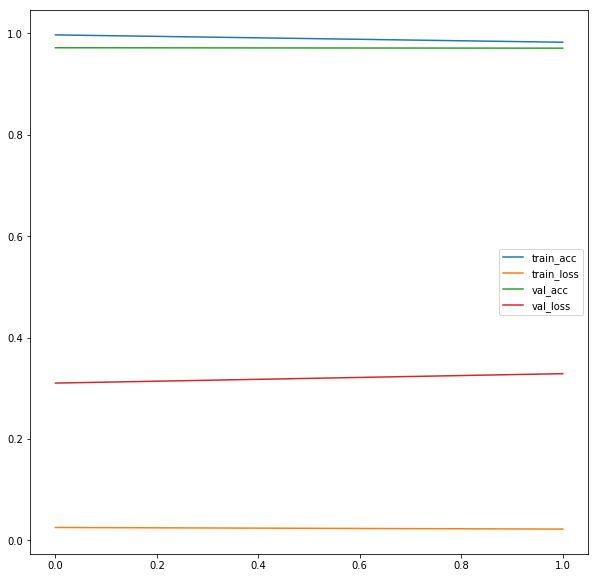

In [80]:
df.plot()

## Saving

In [25]:
model_dir = data_dir + '/mxnet_models'

In [26]:
model_name = "test_mxnet_model_v1_96"

In [27]:
my_net.save_parameters(os.path.join(model_dir, model_name))

## Visualizing trainign and validation accuracy and loss

In [28]:
my_net.

SyntaxError: invalid syntax (<ipython-input-28-b1758a28d02b>, line 1)

## Loading the saved models

In [29]:
my_net.load_parameters(os.path.join(model_dir, model_name))

## Testing

In [ ]:
true_labels = mx.nd.array([2])

In [ ]:
true_labels

In [ ]:
temp = mx.nd.array([1,2,3])

In [ ]:
temp

In [ ]:
true_labels = mx.ndarray.concat(true_labels, temp, dim=0)

In [ ]:
true_labels.asnumpy()

In [ ]:
temp

In [30]:
acc = mx.metric.Accuracy()

all_true_labels = np.array([])#mx.nd.array([0])
#temp = mx.nd.array([1,2,3,4,5])
#all_predicted_labels = []
all_predicted_labels_device = mx.nd.array([-1], ctx=ctx) # mx.nd


for i,(data, label) in enumerate(dataloader_test):
    
    data = data.astype(np.float32).as_in_context(ctx) # loading data to GPU if available
    l = label.asnumpy()
    # label = label #.as_in_context(ctx) # loading data to GPU if available
   # all_true_labels = mx.ndarray.concat(all_true_labels,l, dim=0 )
    all_true_labels = np.concatenate((all_true_labels,l))
    print(l)
    print("====")
    print(label)
    print("====")
    print(len(all_true_labels))
    
    with autograd.predict_mode():
        probability=my_net(data)
        predictions = nd.argmax(probability, axis=1)
        all_predicted_labels_device = mx.ndarray.concat(all_predicted_labels_device, predictions, dim=0)
        print(predictions)
        acc.update(preds=predictions, labels=label)
      #  print(acc.get()[1])
        #all_true_labels.extend(label)
       
        #all_predicted_labels.extend(predictions)
        print("gpu array =",all_predicted_labels_device)
      #  print(label)
       

    

[7 1 4 5 0 1 4 2 3 5 7 6 5 6 7 3 6 7 4 5 1 3 7 4 6 1 4 2 6 4 7 5]
====

[7 1 4 5 0 1 4 2 3 5 7 6 5 6 7 3 6 7 4 5 1 3 7 4 6 1 4 2 6 4 7 5]
<NDArray 32 @cpu_shared(0)>
====
32

[7. 1. 4. 5. 0. 1. 4. 5. 7. 5. 7. 7. 5. 6. 7. 3. 6. 7. 4. 5. 1. 3. 7. 4.
 6. 1. 4. 2. 6. 4. 6. 5.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1.  4.  5.  0.  1.  4.  5.  7.  5.  7.  7.  5.  6.  7.  3.  6.
  7.  4.  5.  1.  3.  7.  4.  6.  1.  4.  2.  6.  4.  6.  5.]
<NDArray 33 @gpu(0)>
[4 0 2 1 4 2 7 4 5 0 1 4 7 2 6 3 4 7 1 4 2 7 5 0 6 1 5 1 6 1 3 1]
====

[4 0 2 1 4 2 7 4 5 0 1 4 7 2 6 3 4 7 1 4 2 7 5 0 6 1 5 1 6 1 3 1]
<NDArray 32 @cpu_shared(0)>
====
64

[4. 0. 2. 1. 4. 2. 7. 4. 2. 0. 1. 4. 7. 5. 6. 3. 4. 7. 1. 4. 2. 7. 4. 0.
 6. 1. 5. 1. 6. 1. 3. 1.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1.  4.  5.  0.  1.  4.  5.  7.  5.  7.  7.  5.  6.  7.  3.  6.
  7.  4.  5.  1.  3.  7.  4.  6.  1.  4.  2.  6.  4.  6.  5.  4.  0.  2.
  1.  4.  2.  7.  4.  2.  0.  1.  4.  7.  5.  6.  3.  4.  7.  1.  4.  2.
  7.  4. 

[1 5 2 2 5 2 4 0 3 0 4 0 6 6 7 0 0 4 1 4 3 6 6 6 2 7 3 0 1 3 2 7]
====

[1 5 2 2 5 2 4 0 3 0 4 0 6 6 7 0 0 4 1 4 3 6 6 6 2 7 3 0 1 3 2 7]
<NDArray 32 @cpu_shared(0)>
====
352

[1. 2. 2. 5. 5. 5. 4. 0. 3. 0. 4. 0. 6. 6. 7. 0. 0. 4. 1. 4. 3. 6. 6. 7.
 2. 7. 3. 1. 0. 3. 2. 7.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1.  4.  5.  0.  1.  4.  5.  7.  5.  7.  7.  5.  6.  7.  3.  6.
  7.  4.  5.  1.  3.  7.  4.  6.  1.  4.  2.  6.  4.  6.  5.  4.  0.  2.
  1.  4.  2.  7.  4.  2.  0.  1.  4.  7.  5.  6.  3.  4.  7.  1.  4.  2.
  7.  4.  0.  6.  1.  5.  1.  6.  1.  3.  1.  2.  3.  2.  2.  4.  5.  0.
  0.  3.  3.  0.  2.  5.  4.  7.  2.  6.  3.  3.  5.  0.  0.  6.  1.  2.
  7.  2.  4.  7.  1.  4.  5.  6.  2.  1.  4.  3.  5.  0.  5.  1.  7.  6.
  6.  5.  4.  3.  3.  7.  0.  0.  4.  2.  3.  4.  2.  5.  1.  4.  1.  6.
  7.  6.  3.  4.  5.  7.  5.  5.  2.  4.  1.  5.  1.  7.  7.  0.  1.  4.
  5.  2.  4.  6.  0.  1.  2.  5.  3.  5.  5.  3.  5.  5.  0.  1.  2.  0.
  3.  0.  7.  1.  4.  7.  6.  3.  


[2. 5. 0. 3. 6. 7. 1. 3. 6. 2. 4. 2. 5. 2. 4. 0. 4. 3. 1. 3. 4. 7. 2. 1.
 4. 4. 4. 4. 1. 3. 7. 2.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1.  4.  5.  0.  1.  4.  5.  7.  5.  7.  7.  5.  6.  7.  3.  6.
  7.  4.  5.  1.  3.  7.  4.  6.  1.  4.  2.  6.  4.  6.  5.  4.  0.  2.
  1.  4.  2.  7.  4.  2.  0.  1.  4.  7.  5.  6.  3.  4.  7.  1.  4.  2.
  7.  4.  0.  6.  1.  5.  1.  6.  1.  3.  1.  2.  3.  2.  2.  4.  5.  0.
  0.  3.  3.  0.  2.  5.  4.  7.  2.  6.  3.  3.  5.  0.  0.  6.  1.  2.
  7.  2.  4.  7.  1.  4.  5.  6.  2.  1.  4.  3.  5.  0.  5.  1.  7.  6.
  6.  5.  4.  3.  3.  7.  0.  0.  4.  2.  3.  4.  2.  5.  1.  4.  1.  6.
  7.  6.  3.  4.  5.  7.  5.  5.  2.  4.  1.  5.  1.  7.  7.  0.  1.  4.
  5.  2.  4.  6.  0.  1.  2.  5.  3.  5.  5.  3.  5.  5.  0.  1.  2.  0.
  3.  0.  7.  1.  4.  7.  6.  3.  4.  1.  6.  4.  2.  1.  3.  2.  7.  0.
  2.  3.  2.  7.  2.  4.  6.  5.  0.  6.  4.  5.  2.  7.  1.  0.  2.  6.
  7.  5.  2.  6.  0.  4.  2.  5.  4.  0.  3.  5.  2.  5.  6.  6


[2. 6. 2. 6. 7. 1. 2. 2. 5. 7. 3. 2. 7. 6. 5. 2. 1. 0. 2. 0. 3. 0. 2. 7.
 7. 2. 7. 1. 2. 3. 6. 3.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1.  4.  5.  0.  1.  4.  5.  7.  5.  7.  7.  5.  6.  7.  3.  6.
  7.  4.  5.  1.  3.  7.  4.  6.  1.  4.  2.  6.  4.  6.  5.  4.  0.  2.
  1.  4.  2.  7.  4.  2.  0.  1.  4.  7.  5.  6.  3.  4.  7.  1.  4.  2.
  7.  4.  0.  6.  1.  5.  1.  6.  1.  3.  1.  2.  3.  2.  2.  4.  5.  0.
  0.  3.  3.  0.  2.  5.  4.  7.  2.  6.  3.  3.  5.  0.  0.  6.  1.  2.
  7.  2.  4.  7.  1.  4.  5.  6.  2.  1.  4.  3.  5.  0.  5.  1.  7.  6.
  6.  5.  4.  3.  3.  7.  0.  0.  4.  2.  3.  4.  2.  5.  1.  4.  1.  6.
  7.  6.  3.  4.  5.  7.  5.  5.  2.  4.  1.  5.  1.  7.  7.  0.  1.  4.
  5.  2.  4.  6.  0.  1.  2.  5.  3.  5.  5.  3.  5.  5.  0.  1.  2.  0.
  3.  0.  7.  1.  4.  7.  6.  3.  4.  1.  6.  4.  2.  1.  3.  2.  7.  0.
  2.  3.  2.  7.  2.  4.  6.  5.  0.  6.  4.  5.  2.  7.  1.  0.  2.  6.
  7.  5.  2.  6.  0.  4.  2.  5.  4.  0.  3.  5.  2.  5.  6.  6


[7. 0. 2. 6. 3. 7. 1. 2. 3. 0. 5. 6. 7. 3. 4. 3. 3. 6. 2. 4. 5. 6. 0. 2.
 1. 7. 7. 5. 2. 7. 2. 2.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1.  4.  5.  0.  1.  4.  5.  7.  5.  7.  7.  5.  6.  7.  3.  6.
  7.  4.  5.  1.  3.  7.  4.  6.  1.  4.  2.  6.  4.  6.  5.  4.  0.  2.
  1.  4.  2.  7.  4.  2.  0.  1.  4.  7.  5.  6.  3.  4.  7.  1.  4.  2.
  7.  4.  0.  6.  1.  5.  1.  6.  1.  3.  1.  2.  3.  2.  2.  4.  5.  0.
  0.  3.  3.  0.  2.  5.  4.  7.  2.  6.  3.  3.  5.  0.  0.  6.  1.  2.
  7.  2.  4.  7.  1.  4.  5.  6.  2.  1.  4.  3.  5.  0.  5.  1.  7.  6.
  6.  5.  4.  3.  3.  7.  0.  0.  4.  2.  3.  4.  2.  5.  1.  4.  1.  6.
  7.  6.  3.  4.  5.  7.  5.  5.  2.  4.  1.  5.  1.  7.  7.  0.  1.  4.
  5.  2.  4.  6.  0.  1.  2.  5.  3.  5.  5.  3.  5.  5.  0.  1.  2.  0.
  3.  0.  7.  1.  4.  7.  6.  3.  4.  1.  6.  4.  2.  1.  3.  2.  7.  0.
  2.  3.  2.  7.  2.  4.  6.  5.  0.  6.  4.  5.  2.  7.  1.  0.  2.  6.
  7.  5.  2.  6.  0.  4.  2.  5.  4.  0.  3.  5.  2.  5.  6.  6

====

[4 1 7 6 2 1 1 3 1 2 5 6 3 3 1 1 5 1 5 3 0 5 5 2 7 3 1 4 2 0 1 7]
<NDArray 32 @cpu_shared(0)>
====
896

[4. 1. 7. 6. 2. 1. 1. 7. 1. 2. 5. 6. 3. 3. 1. 1. 2. 1. 2. 3. 0. 5. 5. 5.
 7. 3. 1. 4. 2. 0. 1. 7.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1.  4.  5.  0.  1.  4.  5.  7.  5.  7.  7.  5.  6.  7.  3.  6.
  7.  4.  5.  1.  3.  7.  4.  6.  1.  4.  2.  6.  4.  6.  5.  4.  0.  2.
  1.  4.  2.  7.  4.  2.  0.  1.  4.  7.  5.  6.  3.  4.  7.  1.  4.  2.
  7.  4.  0.  6.  1.  5.  1.  6.  1.  3.  1.  2.  3.  2.  2.  4.  5.  0.
  0.  3.  3.  0.  2.  5.  4.  7.  2.  6.  3.  3.  5.  0.  0.  6.  1.  2.
  7.  2.  4.  7.  1.  4.  5.  6.  2.  1.  4.  3.  5.  0.  5.  1.  7.  6.
  6.  5.  4.  3.  3.  7.  0.  0.  4.  2.  3.  4.  2.  5.  1.  4.  1.  6.
  7.  6.  3.  4.  5.  7.  5.  5.  2.  4.  1.  5.  1.  7.  7.  0.  1.  4.
  5.  2.  4.  6.  0.  1.  2.  5.  3.  5.  5.  3.  5.  5.  0.  1.  2.  0.
  3.  0.  7.  1.  4.  7.  6.  3.  4.  1.  6.  4.  2.  1.  3.  2.  7.  0.
  2.  3.  2.  7.  2.  4.  6


[3. 2. 6. 7. 0. 2. 4. 3. 0. 7. 3. 1. 7. 5. 3. 7. 1. 2. 4. 4. 7. 5. 2. 0.
 2. 0. 5. 5. 6. 1. 0. 3.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1. ...  1.  0.  3.]
<NDArray 1057 @gpu(0)>
[0 3 0 3 0 7 5 6 1 6 3 4 6 6 4 1 1 1 2 6 6 2 6 4 3 0 1 6 7 3 2 2]
====

[0 3 0 3 0 7 5 6 1 6 3 4 6 6 4 1 1 1 2 6 6 2 6 4 3 0 1 6 7 3 2 2]
<NDArray 32 @cpu_shared(0)>
====
1088

[0. 3. 0. 3. 0. 7. 2. 6. 1. 6. 3. 4. 6. 6. 4. 1. 1. 1. 5. 6. 6. 2. 6. 4.
 3. 0. 1. 6. 7. 3. 2. 2.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1. ...  3.  2.  2.]
<NDArray 1089 @gpu(0)>
[6 1 0 2 6 2 3 2 4 3 2 0 0 0 2 7 4 5 5 1 7 0 6 6 1 2 4 3 0 2 5 7]
====

[6 1 0 2 6 2 3 2 4 3 2 0 0 0 2 7 4 5 5 1 7 0 6 6 1 2 4 3 0 2 5 7]
<NDArray 32 @cpu_shared(0)>
====
1120

[6. 0. 0. 2. 6. 2. 3. 2. 4. 3. 2. 0. 0. 0. 2. 7. 4. 2. 5. 1. 7. 0. 6. 6.
 0. 2. 4. 3. 0. 2. 5. 7.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  1. ...  2.  5.  7.]
<NDArray 1121 @gpu(0)>
[5 5 0 1 0 0 2 6 2 7 7 1 2 7 1 6 0 2 2 5 0 1 4 1 7 3 5 2 1 2 6 3]
====

[5 5 0 1 0 0 2 

In [ ]:
all_true_labels


In [ ]:
all_predicted_labels_device

In [31]:
all_predicted_labels_cpu = all_predicted_labels_device.as_in_context(mx.cpu())

In [32]:
all_predicted_labels_cpu = all_predicted_labels_cpu[1:].asnumpy()

In [ ]:
all_predicted_labels_cpu

In [33]:
from sklearn.metrics import confusion_matrix

In [ ]:
all_true_labels

In [34]:
#  Generate confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels_cpu)

In [35]:
cm

array([[187,  11,   0,   0,   0,   0,   2,   0],
       [ 16, 184,   0,   0,   0,   0,   0,   0],
       [  0,   0, 164,   0,   0,  36,   0,   0],
       [  0,   0,   0, 195,   0,   0,   0,   5],
       [  0,   0,   1,   0, 198,   0,   1,   0],
       [  0,   0,  45,   0,   1, 153,   1,   0],
       [  0,   0,   0,   8,   4,   0, 179,   9],
       [  0,   2,   1,   3,   0,   0,   4, 190]])

In [36]:
# for i, (data, label) in enumerate(dataloader_t):
 # with autograd.predict_mode():
    

In [37]:
def plot_training_history(history, dir, plt_name):
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    df = pd.DataFrame({'train_acc':train_acc, 'train_loss':train_loss, 'val_acc':val_acc, 'val_loss':val_loss})
    pie = df.plot()
    fig = pie.get_figure()
    #fig.savefig(os.path.join(plot_dir, acc_loss_plot_name))
    fig.savefig(os.path.join(dir, plt_name))

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          plt_size=[10,10]):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = plt_size
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(plot_dir, cm_plot_name))

In [39]:
plot_dir  = data_dir + '/mxnet_plots'

In [40]:
cm_plot_name = 'cm_'+model_name

Confusion matrix, without normalization
[[187  11   0   0   0   0   2   0]
 [ 16 184   0   0   0   0   0   0]
 [  0   0 164   0   0  36   0   0]
 [  0   0   0 195   0   0   0   5]
 [  0   0   1   0 198   0   1   0]
 [  0   0  45   0   1 153   1   0]
 [  0   0   0   8   4   0 179   9]
 [  0   2   1   3   0   0   4 190]]


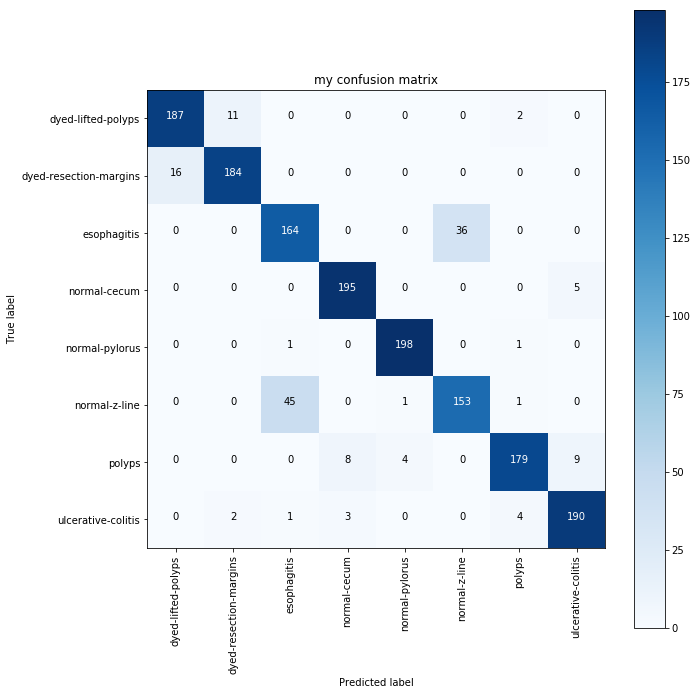

In [41]:
plot_confusion_matrix(cm, classes=categories, title='my confusion matrix')